# Report 2
## Mafalda Borges

In [2]:
from __future__ import print_function, division

import numpy as np

import thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Beta, MakeBinomialPmf
import thinkplot
from scipy import special

% matplotlib inline

# The Chess Problem
The following problem was taken from a quiz by Allen Downey.

Two identical twins are members of my chess club, but they never show up on the same day; in fact, they strictly alternate the days they show up.  I can't tell them apart except that one is a better player than the other:  Avery beats me 60% of the time and I beat Blake 70% of the time.  If I play one twin on Monday and win, and the other twin on Tuesday and lose, which twin did I play on which day?

For this problem, let's assume that it is equally likely that either scenario could occur. Hypothesis one is that I play Avery first and then Blake second, with hypothesis two being the opposite. I also know how often I win or lose against each one and I will multiply these probabilities to get my likelihood. Now I can set up my problem.

In [40]:
pmfChess = Pmf()
pmfChess['AveryBlake'] = 0.5
pmfChess['BlakeAvery'] = 0.5
pmfChess.Mult('AveryBlake', 0.4*0.3)
pmfChess.Mult('BlakeAvery', 0.6*0.7)
pmfChess.Normalize()
pmfChess.Print()

AveryBlake 0.222222222222
BlakeAvery 0.777777777778


This model predicts there was roughly a 78% chance you played Blake and then Avery. 

## The Euro Problem
The following problem has been taken from *Information Theory, Inference, and Learning Algorithms* by David Mackay. 

When spun on edge 250 times, a Belgian one-euro coin
came up heads 140 times and tails 110. ‘It looks very
suspicious to me,’ said Barry Blight, a statistics lecturer
at the London School of Economics. ‘If the coin were
unbiased, the chance of getting a result as extreme as
that would be less than 7%.'

I first set up a uniform distribution as my prior. 

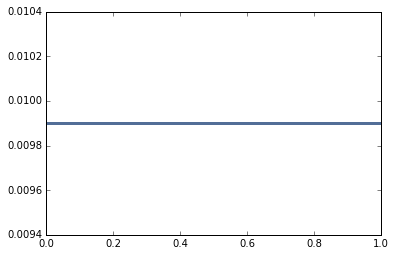

In [6]:
uniformEuro = Beta(1,1, label = 'uniform')
thinkplot.Pdf(uniformEuro.MakePmf())

Next I updated this information by feeding in the data from the problem or a result of 140 heads and 110 tails. 

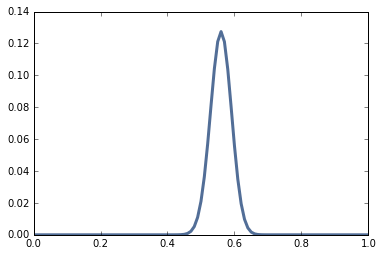

In [7]:
dataset = 140, 110
uniformEuro.Update(dataset)
thinkplot.Pdf(uniformEuro.MakePmf())

I tried this problem again but this time I used a beta distribution as my prior which assumes a fair coin.

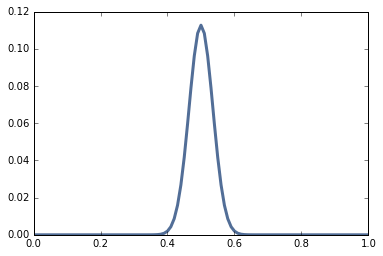

In [9]:
betaEuro = Beta(100,100, label = 'beta')
thinkplot.Pdf(betaEuro.MakePmf())

Once again I updated my model with the same dataset. 

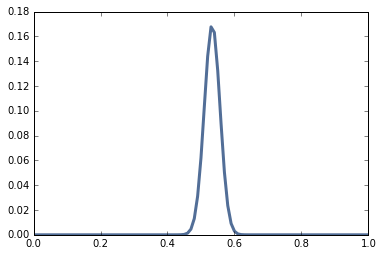

In [12]:
betaEuro.Update(dataset)
thinkplot.Pdf(betaEuro.MakePmf())

Let's compare the two distributions. 

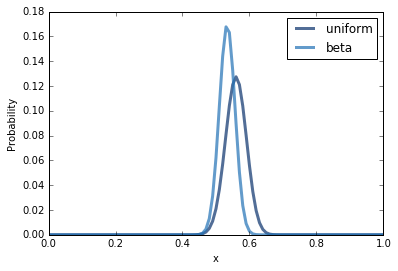

In [13]:
thinkplot.Pdf(uniformEuro.MakePmf())
thinkplot.Pdf(betaEuro.MakePmf())
thinkplot.Config(xlabel = 'x', ylabel = 'Probability')

This shows that the informative prior opposed to the uniformative prior has a narrower spread, and a slightly different location, showing the how the prior is selected can have large effects on the final results. 

## Women's Skeet Event
The next problem was taken from Allen Downey's workbook. 

At the 2016 Summer Olympics in the Women's Skeet event, Kim Rhode faced Wei Meng in the bronze medal match. They each hit 15 of 25 skeets, sending the match into sudden death. In the first round, both hit 1 of 2 skeets. In the next two rounds, they each hit 2 skeets. Finally, in the fourth round, Rhode hit 2 and Wei hit 1, so Rhode won the bronze medal, making her the first Summer Olympian to win an individual medal at six consecutive summer games.

But after all that shooting, what is the probability that Rhode is actually a better shooter than Wei? If the same match were held again, what is the probability that Rhode would win?

I used a beta function as my prior, which I set up using data from the final round of skeet shooting for women in the 2012 London Olympics. I found the mean number of clays that were successfully shot (which was 22) and missed (3) and used these numbers to set up my beta function. From this I can create a model to compare the two shooters.

In [14]:
rhode = Beta(22,3, label = "Rhode")
rhode.Update((22,11))
wei=Beta(22,3,label='Wei')
wei.Update((21,12))

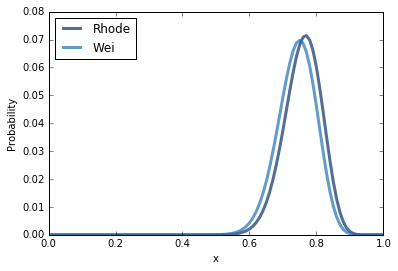

In [15]:
thinkplot.Pdf(rhode.MakePmf())
thinkplot.Pdf(wei.MakePmf())
thinkplot.Config(loc = "upper left", xlabel = 'x', ylabel = 'Probability')

Now I have a model to predict who is a better shooter. I can take data from it (the posteriors) and compare them.

In [41]:
rhode_sample = rhode.MakeCdf(10001).Sample(10000)
wei_sample = wei.MakeCdf(10001).Sample(10000)
np.mean(rhode_sample > wei_sample)

0.58099999999999996

In [42]:
np.mean(rhode_sample < wei_sample)

0.41820000000000002

My model predicts that the probability that Rhode is a better shooter than Wei is 58%. 

Next I want to look at what would happen if there is a rematch. I can do this by drawing random samples of 'p' the probability of being a better shooter from my posterior distribution, and create a binomial distribution using 'p' and an n of 25. 

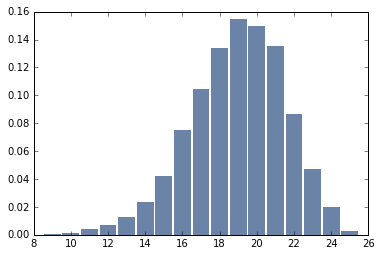

In [18]:
rhode_rematch = np.random.binomial(25, rhode_sample)
thinkplot.Hist(Pmf(rhode_rematch))

In [19]:
wei_rematch = np.random.binomial(25, wei_sample)
np.mean(rhode_rematch > wei_rematch)

0.49930000000000002

In [21]:
np.mean(rhode_rematch < wei_rematch)

0.3947

In [22]:
np.mean(rhode_rematch == wei_rematch)

0.106

My model predicts that there is a 50% chance Rhode wins in normal time, a 39% chance Wei wins in normal time, and an 11% chance of sudden death. 

# The Coin Toss with a Measuring Device
The next problem was taken from *Think Bayes* by Allen Downey.

Suppose that instead of observing coin tosses directly, you measure the outcome using an instrument that is not always correct. Specifically, suppose there is a probability y that an actual heads is reported as tails, or actual tails reported as heads.
Write a class that estimates the bias of a coin given a series of outcomes and the value of y.
How does the spread of the posterior distribution depend on y?

First let's create a class for the coin to model it.

In [24]:
class UnknownCoin(Suite):
    def __init__(self, prior, y):
        """prior: is the map of possible probabilities
        y: the porbability that the device is accurate"""
        Suite.__init__(self, prior)
        self.y = y
        
    def Likelihood(self, data, hypo):
        """data: the reading of the measurement device
        hypo: the probability of heads"""
        x = hypo/100
        y = self.y
        if data == 'H':
            return x*y + (1-x)*(1-y)
        else:
            return x*(1-y) + (1-x)*y

Lets say that the measurement device is very poor, and that 90% of the time it reports heads as tails or tails as heads. I will create a uniform distribution as my prior. 

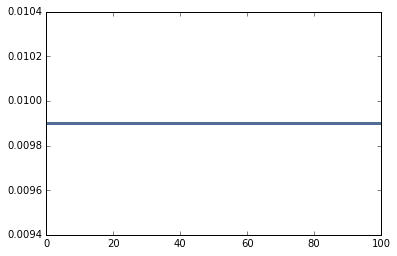

In [33]:
prior = range(0,101)
coinSuite = UnknownCoin(prior, y = 0.9)
thinkplot.Pdf(coinSuite)

Now that the distribution is set up, let's add some data. For example lets have the device report 5 heads and 2 tails. 

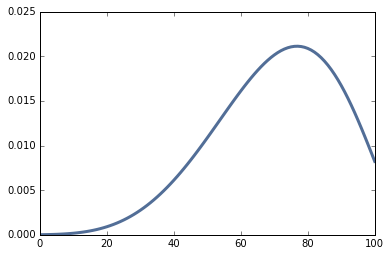

In [34]:
for outcome in 'HHHHHTT':
    coinSuite.Update(outcome)
thinkplot.Pdf(coinSuite)

Let's look how the distribution changes with different values of y.

In [35]:
def new_prior(y):
    prior = range(0,101)
    suite = UnknownCoin(prior, y=y)
    for outcome in 'HHHHHTT':
        suite.Update(outcome)
    thinkplot.Pdf(suite, label='y=%g' % y)

thinkplot.py:115: UserWarning: Ran out of colors.  Starting over.
  warnings.warn('Ran out of colors.  Starting over.')


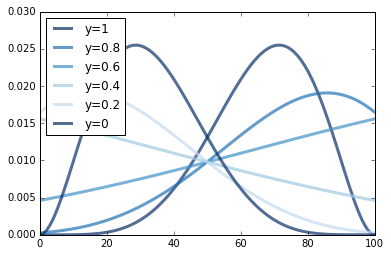

In [36]:
new_prior(1)
new_prior(0.8)
new_prior(0.6)
new_prior(0.4)
new_prior(0.2)
new_prior(0)
thinkplot.config(legend=True)


Lets call x = |y-0.5|. Distributions which have the same x value appear to symmetric around 50% accuracy by the device. As y approches 0.5 the distribution gets wider, being the narrowest at y = 1, and y=0. This shows measuring with a very faulty y=1 device or a very accurate one y=0 will be just as useful for predicting outcomes of the coin, assuming we know the value of y. Devices with a more intermediate accuracy will be less useful.

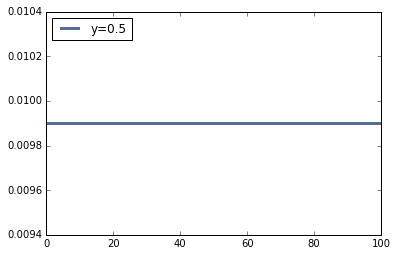

In [37]:
new_prior(0.5)
thinkplot.config(legend=True)

If y = 0.5 or the measurement device gets about half of its measurements wrong the data does not affect the prior so the prior is equal to the posterior meaning the measurement device does not provide any data about the coin.

# The Subreddit Problem
The problem was inspired by a question posted by a “redditor” named dominosci on Reddit’s statistics “subreddit” at http://reddit.com/r/statistics.

Reddit is an online forum with many interest groups called subreddits. Users, called redditors, post links to online content and other web pages. Other redditors vote on the links, giving an “upvote” to high-quality links and a “downvote” to links that are bad or irrelevant.
A problem, identified by dominosci, is that some redditors are more reliable than others, and Reddit does not take this into account.
The challenge is to devise a system so that when a redditor casts a vote, the estimated quality of the link is updated in accordance with the reliability of the redditor, and the estimated reliability of the redditor is updated in accordance with the quality of the link.
One approach is to model the quality of the link as the probability of garnering an upvote, and to model the reliability of the redditor as the probability of correctly giving an upvote to a high-quality item.
Write class definitions for redditors and links and an update function that updates both objects whenever a redditor casts a vote.

Lets define our variables in order to tackle this problem. Each article has a certain quality which will be measured by Q or the probability that a reliable redditor will upvote it. Next we need to give a reliability rating to each redditor or R the probability that a redditor will give an upvote to an article of the highest qualitity (Q=1). Now we can relate the two variables with the probability that a redditor with reliability R giving an upvote to an article of quality Q with the expression R*Q + (1-R)*(1-Q). Now we can create a class to represent the redditor.

In [43]:
class Redditor(Suite):
    """Quantifies the reliability of a redditor"""
    def Likelihood(self,data,hypo):
        """Gives the likelihood of the data given a hypothesis
        hypo: is the probability of a reliable vote (r)
        data: vote up or down and q is the quality of the article"""
        r = hypo/100.0
        vote, q = data
        
        if vote == 'up':
            return r*q + (1-r)*(1-q)
        elif vote == 'down':
            return r*(1-q) + q*(1-r)
        else:
            return 0
        

In [47]:
class Article(Suite):
    """Quantifies the reliability of an article"""
    def Likelihood(self, data, hypo):
        """Gives the likelihood of the data given a hypothesis
        hypo: the value of u which is the probability of an upvote
        data: vote is whether the vote was up or down, and r is
        the reliability of the reddior"""
        u = hypo/100.0
        vote, r = data
        
        if vote == 'up':
            return r*u + (1-r)*(1-u)
        elif vote == 'down':
            return r*(1-u) + u*(1-r)
        else:
            return 0
        
        

Let's start off with a redditor in which we know a little about the reliability, in that he is more reliable than not. I will create a beta distribution as my prior.

0.6699999999999996

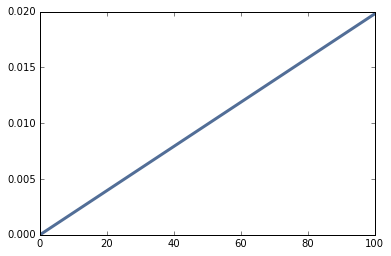

In [45]:
redditor = Redditor(label = 'redditor')
beta = Beta(2,1)
for val, prob in beta.MakePmf().Items():
    redditor.Set(val*100, prob)

thinkplot.Pdf(redditor)
mean_r = redditor.Mean()/100.0
mean_r

Now let's look at the articles. Let's say we know nothing about its qualitty so we will set up a uniform distribution.

0.5000000000000001

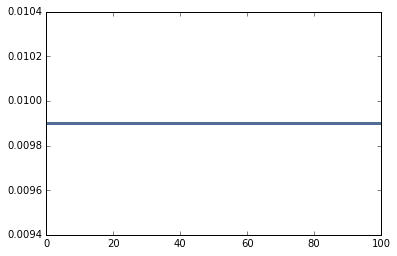

In [48]:
article = Article(range(0,101), label = 'article')
thinkplot.Pdf(article)
mean_q = article.Mean()/100.0
mean_q

Now let's assume our semi-reliable redditor decides to upvote the article.

In [49]:
redditor.Update(('up', mean_q))
article.Update(('up', mean_r))

0.4999999999999999

Because we don't know about the true quality of the item, we cannot evaluate the quality of the redditor.

67.0 (22.0, 98.0)


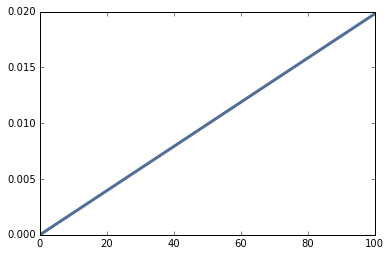

In [50]:
thinkplot.Pdf(redditor)
print(redditor.Mean(), redditor.CredibleInterval(90))

But since we know something about the redditor we can get some more information about the article.

55.78 (7, 97)


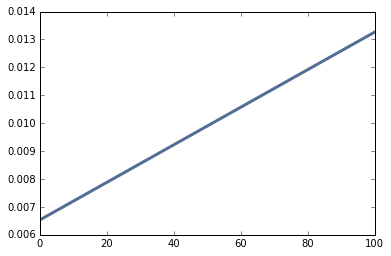

In [51]:
thinkplot.Pdf(article)
print(article.Mean(), article.CredibleInterval(90))

This shows that after the upvote we can guess that the mean quality of the article is about 56% where as before it was 50%.

# Treasure Hunt
This problem was taken from "Understanding Probability" by Henk Tijms.

“It’s believed that a treasure will be in a certain sea area with probability p = 0.4. A search in that area will detect the wreck with probability d = 0.9 if it’s there. What’s the posterior probability of the treasure being in the area when a search didn’t find anything?”

We can set up our priors with the probability of the treasure existing in the area before the search. For the likelihoods we will assume there are no false positives, and we can use the probability of finding the treasure given it was there or not there. 

In [52]:
pmfTreasure = Pmf()
pmfTreasure['MissedTreasure'] = 0.4
pmfTreasure['NoTreasure'] = 0.6
pmfTreasure.Mult('MissedTreasure',0.1)
pmfTreasure.Mult('NoTreasure', 1)
pmfTreasure.Normalize()
pmfTreasure.Print()

MissedTreasure 0.0625
NoTreasure 0.9375


This means that given a search, there is only about a 6% chance there was missed treasure in the area. 

# Allergic to Cats?
This problem was taken from the workbook of Allen Downey

Exercise: Suppose you are having a dinner party with 10 guests and 4 of them are allergic to cats. Because you have cats, you expect 50% of the allergic guests to sneeze during dinner. At the same time, you expect 10% of the non-allergic guests to sneeze. What is the distribution of the total number of guests who sneeze?

We can create a binomial distribution of people who sneeze due to allergies and those that just sneeze. Then we can add them to create one distribution and from there we can find the mean number of sneezing guests.

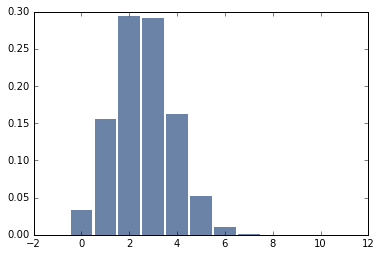

In [5]:
allergic = 4
not_allergic = 6
allergic_sneeze = .5
not_allergic_sneeze = .1

pmf = MakeBinomialPmf(allergic, allergic_sneeze) + MakeBinomialPmf(not_allergic, not_allergic_sneeze)
thinkplot.Hist(pmf)

In [6]:
pmf.Mean()

2.6000000000000014

On average, you will have 2.6 sneezing guests so 2 sneezing and 1 sniffling. 

# Original Problem: More Skeet Shooting

While trying to solve the Rhode Wei problem I started to research skeet shooting. From in the 1968-1992 Olympics shooting events were mixed genders but afterwards the two divisions split after a woman won at the skeet shooting even in Barcelona. Before the event had been won by men. If the men and women were to combine at the next Olympics who would win?

For my priors I took data from the 1988 Olympics, and the 1992 Olympics which were mixed genders and showed both a man and woman winning. I then combined these totals. I only took data from the winners of final rounds of the shooting for a few reasons. First the final round is always out of 25 but the qualifying rounds have differed depending on year and gender, and second the rules of skeet shooting have changed. It used to be a cummulative sport, in that whoever shot the most clays after all three rounds won, but now the scores are wiped after each round, so a person could theoretically win the competition now by shooting fewer clays overall than a fellow competitor. The data for the women has fewer entries because they were barred from competing in 1996. All of the information is courtesy of Wikipedia.

In [11]:
women = Beta(47, 3, label = 'Women')
men = Beta(47,3, label = 'Men')

Now comes the fun part, inputing all the data. It is just the winning scores from the final rounds of skeet shooting at the Olympics post 1992. 

In [12]:
women.Update((25,0))
women.Update((25,0))
women.Update((21,4))
women.Update((25,0))
women.Update((15,10))

men.Update((24,1))
men.Update((25,0))
men.Update((25,0))
men.Update((24,1))
men.Update((25,0))
men.Update((16,9))

Like in the Rhode Wei problem we can visualize the data. 

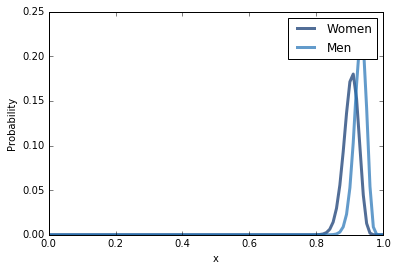

In [13]:
thinkplot.Pdf(women.MakePmf())
thinkplot.Pdf(men.MakePmf())
thinkplot.Config(xlabel = 'x', ylabel = 'Probability')

Now we can estimate the probability of superiority by drawing samples from each group.The 

In [14]:
women_sample = women.MakeCdf(10001).Sample(10000)
men_sample = men.MakeCdf(10001).Sample(10000)
np.mean(women_sample > men_sample)

0.16619999999999999

In [15]:
np.mean(men_sample > women_sample)

0.83279999999999998

In [16]:
np.mean(men_sample == women_sample)

0.001

Now let's look at what happens if we simmulate them competing mixed again in the 2020 Olympics. 

In [17]:
mixed_women = np.random.binomial(25, women_sample)
mixed_men = np.random.binomial(25, men_sample)
np.mean(mixed_women > mixed_men)

0.2823

In [18]:
np.mean(mixed_men > mixed_women)

0.52980000000000005

In [19]:
np.mean(mixed_men == mixed_women)

0.18790000000000001

Based on the data from the previous years, it looks like the men have a strong edge on the women (53% chance of winning vs 28% chance), so a mixed group may not be the best idea for future Olympics.